## **Project 7 - Introduction to Neural Networks**

### **Title**: *Bank Churn Prediction*

### **Author**: *Pankaj Singh*

<br>

**Domain** 

Market analytics/Customer prediction

**Project Context**

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Data Description** 

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

**Customer Information** 

- **`CustomerId`** : Unique ID which is assigned to each customer <br>
- **`Surname`** : Last name of the customer <br>
- **`CreditScore`** : It defines the credit history of the customer <br>
- **`Geography`** : A customer’s location <br>
- **`Gender`** : It defines the Gender of the customer <br>
- **`Age`** : Age of the customer  <br>
- **`Tenure`** : Number of years for which the customer has been with the bank <br>
- **`NumOfProducts`** : It refers to the number of products that a customer has purchased through the bank. <br>
- **`Balance`** : Account balance <br>
- **`HasCrCard`** : It is a categorical variable that decides whether the customer has a credit card or not. <br>
- **`EstimatedSalary`** : Estimated salary <br>
- **`isActiveMember`** : It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc ) <br>
- **`Excited`** : It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values
  - 0=No ( Customer did not leave the bank )
  - 1=Yes ( Customer left the bank ) <br>

**Project Deliverables**

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Learning Objective**

- Explore and visualize the dataset.
- Data preprocessing
- Neural Network implementation on dataset
- Generate a set of insights and recommendations that will help the bank

## **Import Libraries**

In [46]:
import pandas as pd
import numpy as np
import warnings
import random

#!pip install -q shap # Run this if you do not have shap installed
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, fbeta_score, precision_recall_curve 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend
from keras import callbacks
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load data \& get a first glimpse**

In [47]:
# Load data from csv file
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PGPAIML/introtoNN/Project/bank.csv")
cust = data.copy()

- #### Shape of the dataset

In [48]:
## Print out the shape of the dataset
cust.shape

(10000, 14)

- So we have 10000 entries of our data
- We have 14 columns in our dataset

- #### A peek at the 5 random rows of the dataset

In [49]:
## Print out the random 5 rows of the data
cust.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- #### Drop the redundant columns

- `RowNumber` does not seem to provide any useful information and is reduntant due to default indexing, so we will drop the `RowNumber` column
- `CustomerId` also doesn't add a lot of information but we will keep it for initial part of analysis to identify any customer who changed their habits. These are the entries with same `CustomerId` but different values for other features.

In [50]:
cust.drop(["RowNumber"], axis=1, inplace=True)

- #### Look at the column names

In [51]:
## show the number of columns and column names
print("Total number of columns : ", len(cust.columns))
print("\nColumn names : \n\n", cust.columns.to_list())

Total number of columns :  13

Column names : 

 ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


- #### Look at the missing values

In [52]:
# Show the null values
print("Missing values : \n")
print(cust.isnull().sum().sort_values())

Missing values : 

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


- No missing values in the original dataset

- #### Check for duplicate values

In [53]:
cust.duplicated().value_counts()

False    10000
dtype: int64

- There are no duplicate values in the dataset

- #### Convert all column names to lower case and replace any spaces with underscore

In [54]:
cust.columns = cust.columns.str.lower()
cust.columns = cust.columns.str.replace(" ", "_")

- #### Pulling together numerical column names

In [55]:
print(cust.columns)
cust.dtypes

Index(['customerid', 'surname', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited'],
      dtype='object')


customerid           int64
surname             object
creditscore          int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [56]:
# created list of numerical and categorical columns list
numcols = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
catcols = ['customerid', 'surname', 'geography', 'gender', 'hascrcard', 'isactivemember', 'exited']

- #### Look at the simple statistical distribution of data

In [57]:
cust[numcols].describe().T

,count,mean,std,min,25%,50%,75%,max
creditscore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
numofproducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
estimatedsalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


- #### Migrate `numofproducts` from numcols to catcols

In [58]:
numcols.remove('numofproducts')
catcols.append('numofproducts')

- #### Value counts for `customerid`


In [59]:
cust_key_val_counts = cust["customerid"].value_counts()
cust_key_val_counts[cust_key_val_counts > 1]

Series([], Name: customerid, dtype: int64)

- As we can see that there are no entries which have duplicate `customerid` value.
- We will drop the `customerid` column.

In [60]:
cust.drop(["customerid"], axis=1, inplace=True)

- #### Value counts for `surname`

In [61]:
cust["surname"].value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: surname, Length: 2932, dtype: int64

- As we can see that there are 2932 unique surnames, with smith being the most common surnames
- Having this column doesn't add any value so we will drop it.

In [62]:
cust.drop(["surname"], axis=1, inplace=True)

We will also remove `customerid` and `surname` from the catcols list.

In [63]:
catcols.remove('customerid')
catcols.remove('surname')

- #### Get the value counts for the categorical features

In [64]:
for cat in catcols:
  print('\n%-----', cat.upper(), '-----% \n')
  print(cust[cat].value_counts())
  print('--'*20)


%----- GEOGRAPHY -----% 

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
----------------------------------------

%----- GENDER -----% 

Male      5457
Female    4543
Name: gender, dtype: int64
----------------------------------------

%----- HASCRCARD -----% 

1    7055
0    2945
Name: hascrcard, dtype: int64
----------------------------------------

%----- ISACTIVEMEMBER -----% 

1    5151
0    4849
Name: isactivemember, dtype: int64
----------------------------------------

%----- EXITED -----% 

0    7963
1    2037
Name: exited, dtype: int64
----------------------------------------

%----- NUMOFPRODUCTS -----% 

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64
----------------------------------------


- ### **Observations**:

- There are 10000 rows in this data set and 13 columns

- After reviewing columns named `rownumber`, `customerid` and `surname`, we decided to drop them, as the information in those columns doesn't add any extra value to our analysis.

- There are no missing values in the dataset

- #### **Numerical features**

    - The mean and median for creditscore are 650.5 and 652.0 respectively. There is a very slight left skew in data.
      - The highest value for this feature is 850 and minimum is 350.
      - The distribution seems almost uniform

    - The mean and median for age are 39 and 37 respectively. There is a very right skew in data.
      - The highest value for this feature is 92 and minimum is 18
    
    - The mean and median for tenure are 5.01 and 5.0 respectively. This looks like a normal distribution.
      - The highest value for this feature is 10 and minimum is 0.
    
    - The mean and median for balance are 76500 and 97200 respectively. This looks like a left skew distribution.
      - The highest value for this feature is 251000 and minimum is 0.

    - The mean and median for numofproducts are 1.5 and 1 respectively. This looks like a right skew distribution.
      - The highest value for this feature is 4 and minimum is 1.
      - It is a categorical variable and we will keep it in current state and analyze it along with the catergorical variables

    - The mean and median for estimatedsalary are 100090 and 100190 respectively. This looks like a left skew distribution but for most practical purposes it is a normal distribution
      - The highest value for this feature is 200000 and minimum is 12.


- #### **Categorical features**

  - 50% of customers are in France, and other 25% each are in Spain and Germany

  - 55% of customers are male and 45% are female

  - 70% of customers have credit card and 30% of them don't.

  - 52% of customers are active members and 48% are not.

  - 51% of customers are using 1 product, 46% customers use 2 products and rest 3% use more than 2 products

  - 20% of customers left the bank and 80% of them continued with the bank.

    - This is the target variable and is not balanced.

## **Exploratory Data Analysis**

- ### Numerical features

In [65]:
# function to show univariate analysis of continuous data columns
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    f2.suptitle("SPREAD OF DATA FOR " + feature, fontsize=18, fontweight="bold")

- #### Looping over all the numerical columns to show histogram barplot

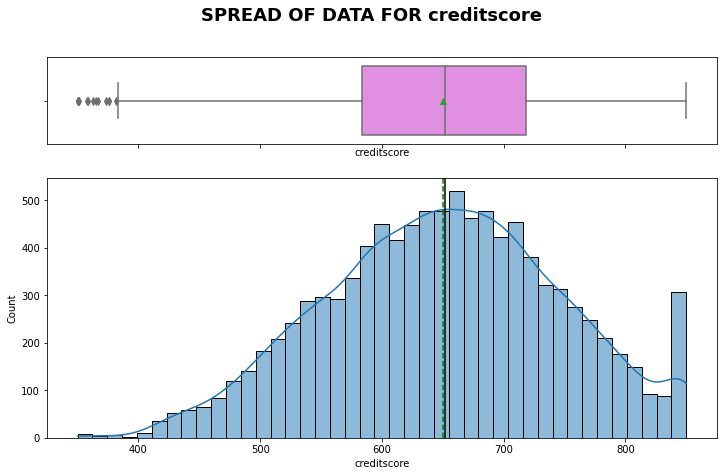

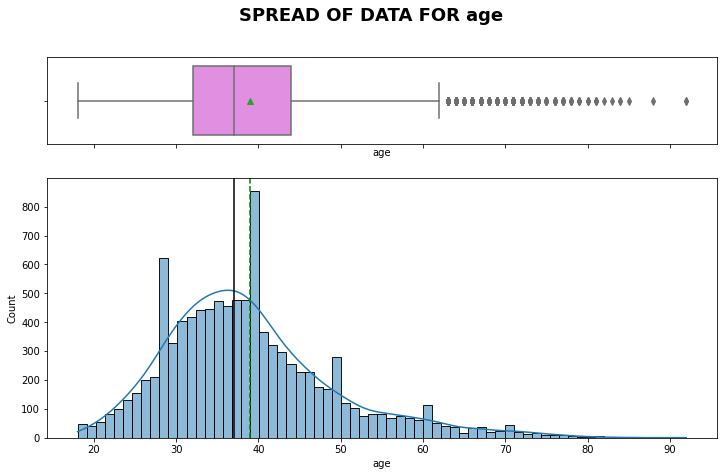

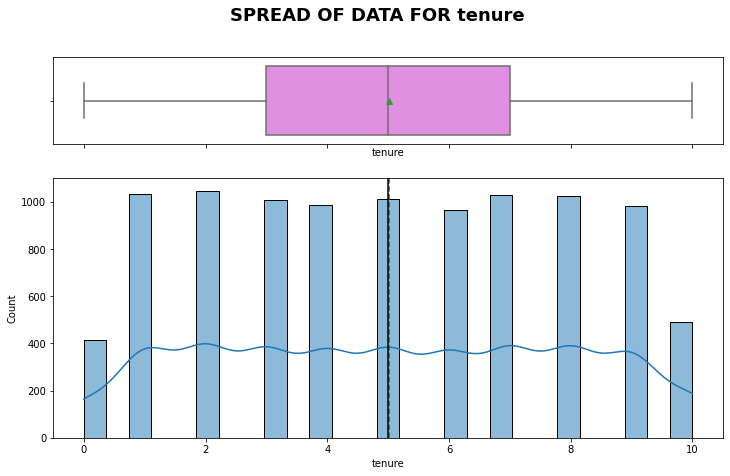

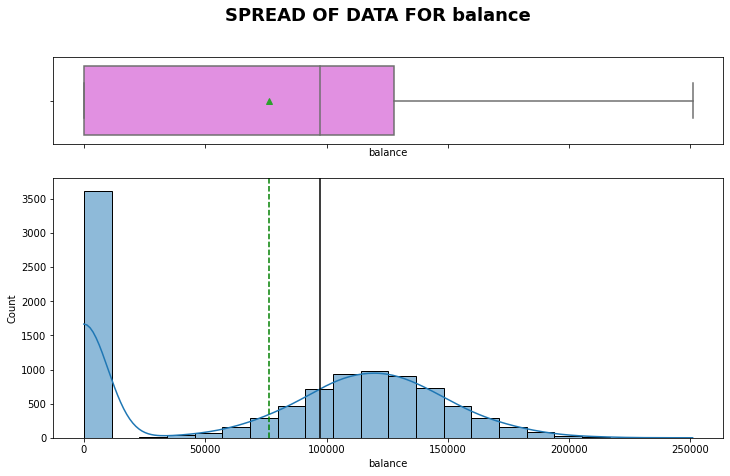

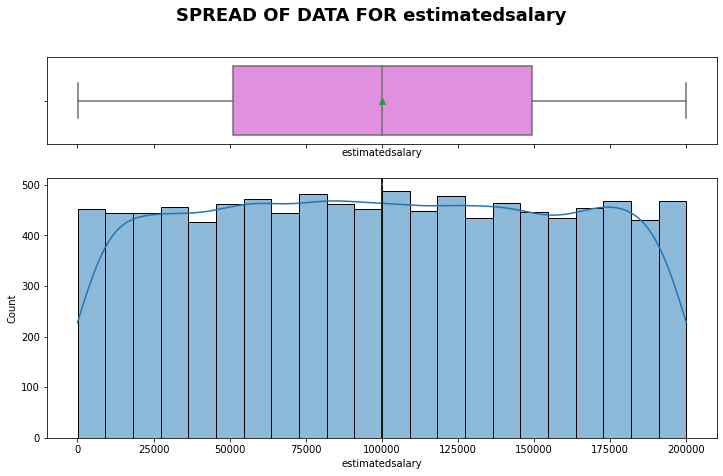

In [66]:
for numcol in numcols:
    histogram_boxplot(cust, numcol, kde=True)

We observe balance without the really small balance, and we can see that the disribution is very uniquely a normal distribution.

count      6382.000000
mean     119845.679127
std       30062.320814
min       12459.190000
25%      100198.862500
50%      119845.850000
75%      139520.260000
max      250898.090000
Name: balance, dtype: float64

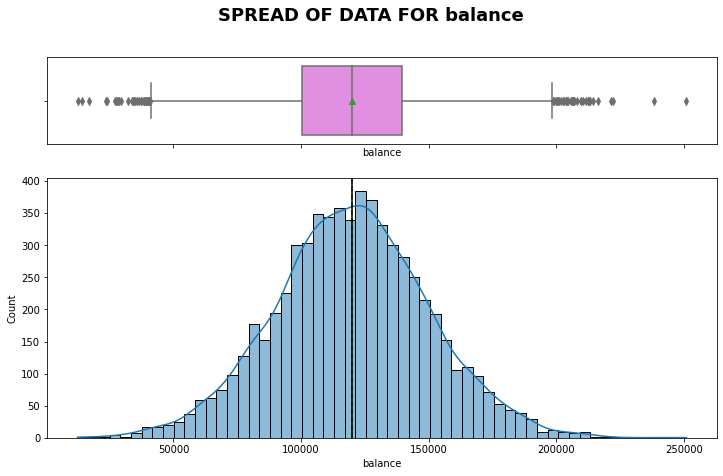

In [67]:
histogram_boxplot(cust[cust['balance'] > 5000], 'balance', kde=True)
cust[cust['balance'] > 5000]['balance'].describe()

### Observations from Single variable distribution

- Creditscore is almost a normal distribution. 
  - There is a large number of customers with high creditscore as it is capped at 850

- Age has a slight long right tail and hence has a slight right skew.
  - There are quite few outliers on the right end of the distribution
  - These outliers are reasonable data points as they represent the age of the customer which ranges between 18 to 90 years. So we will keep those outliers.

- Tenure is almost a uniform distribution 
  - It has no outliers

- Balance can be described as made up of two distributions,
  1. A group of customers (~3500) who have very little balance in their bank accounts
  2. Rest of the customers belong to a normal distribution

- Estimated salary is clearly a uniform distribution
  - There are no outliers

- #### Pairplots

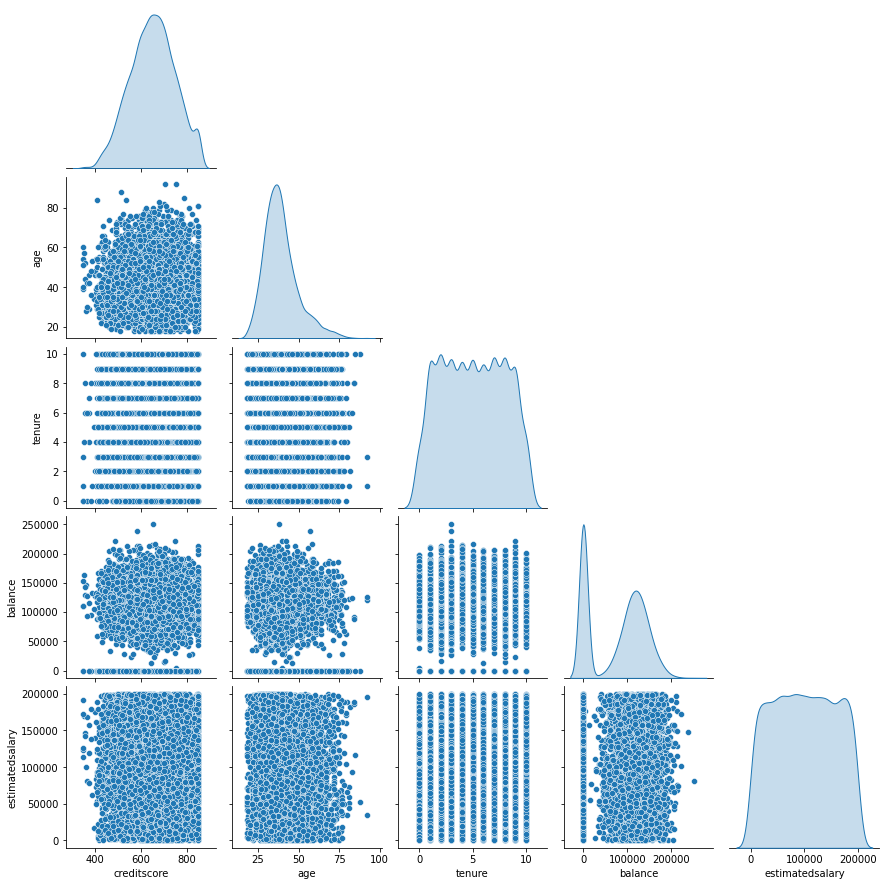

In [68]:
sns.pairplot(cust[numcols], corner=True, diag_kind="kde")

### Observations from Pairplots

- There does not seem to be a strong correlation between any of the features.

- #### Show correlation values

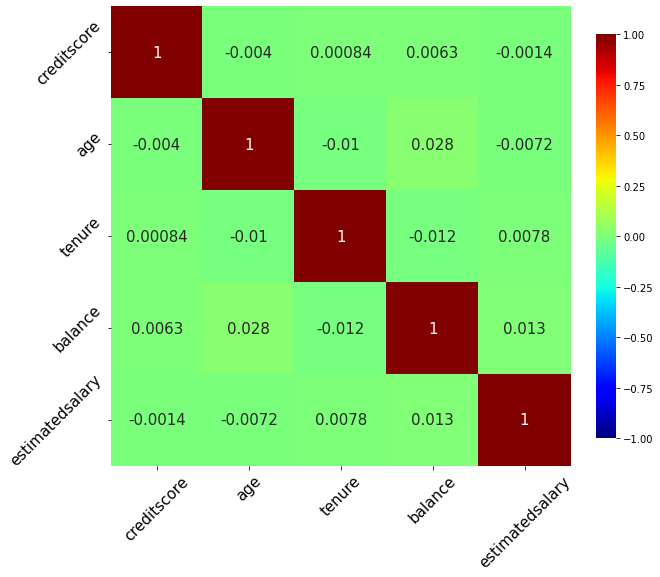

In [69]:
# Show the coorelation of numerical values on a color coded matrix

corr = cust[numcols].corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.tight_layout(pad=2.0)

sns.heatmap(
    corr,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 15},
    cmap="jet",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"fraction": 0.04},
)
ax.tick_params(axis="both", rotation=45, labelsize=15)

### Observations from Correlation map

- As we guessed, there is no significant correlation between the dataset features
  - All the correlation values are less than 0.05

## **Outlier identification and treatment**

Firstly we will identify which columns have significant number of outliers based on the %age data out of boxplot whisker range

In [70]:
## calculate the whisker values to identify outliers in the numerical data
Q1 = cust[numcols].quantile(0.25)
Q3 = cust[numcols].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR


def get_perc_outliers(data, feature, lower, upper):

    print(f"% data beyond upper and lower whiskers for {feature}\n")
    print(
        f"data below lower whisker = {100 * (data[data[feature] < lower].shape[0]) / data.shape[0]:.2f}%"
    )
    print(
        f"data beyond upper whisker = {100 * (data[data[feature] > upper].shape[0]) / data.shape[0]:.2f}%"
    )

    print("-" * 40, "\n")


for numcol in numcols:
    get_perc_outliers(cust, numcol, lower_whisker[numcol], upper_whisker[numcol])

% data beyond upper and lower whiskers for creditscore

data below lower whisker = 0.15%
data beyond upper whisker = 0.00%
---------------------------------------- 

% data beyond upper and lower whiskers for age

data below lower whisker = 0.00%
data beyond upper whisker = 3.59%
---------------------------------------- 

% data beyond upper and lower whiskers for tenure

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 

% data beyond upper and lower whiskers for balance

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 

% data beyond upper and lower whiskers for estimatedsalary

data below lower whisker = 0.00%
data beyond upper whisker = 0.00%
---------------------------------------- 



- creditscore and age have outlier data and it is on the left and right end of the distribution respectively
    - Other features do not have any outliers

- We will leave those outlier values as it is in the dataset as they show values which are relevant and reasonable

- #### Labeled barplot for categorical features

In [71]:
# Function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

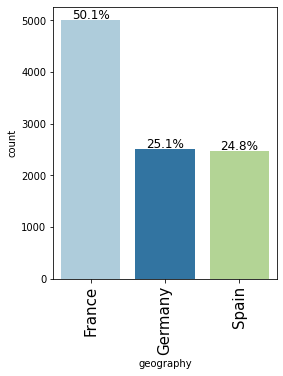

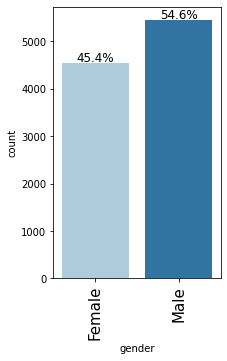

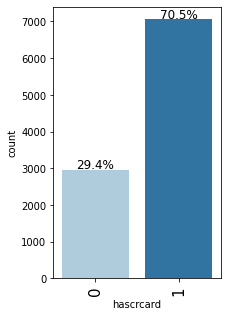

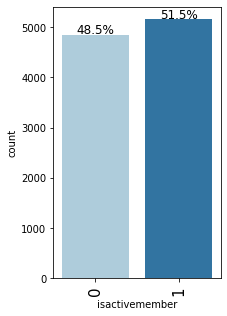

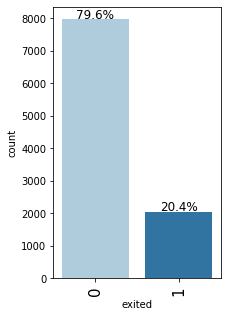

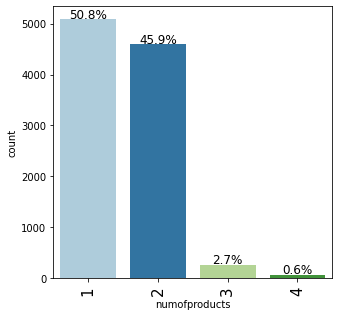

In [72]:
for catcol in catcols:

    labeled_barplot(cust, catcol, perc=True)

- #### **Univariate summary of categorical features**

  - 50% of customers are in France, and other 25% each are in Spain and Germany

  - 55% of customers are male and 45% are female

  - 70% of customers have credit card and 30% of them don't.

  - 52% of customers are active members and 48% are not.

  - 51% of customers are using 1 product, 46% customers use 2 products and rest 3% use more than 2 products

  - 20% of customers left the bank and 80% of them continued with the bank.

    - This is the target variable and is not balanced.

- #### Pie chart of the target variable

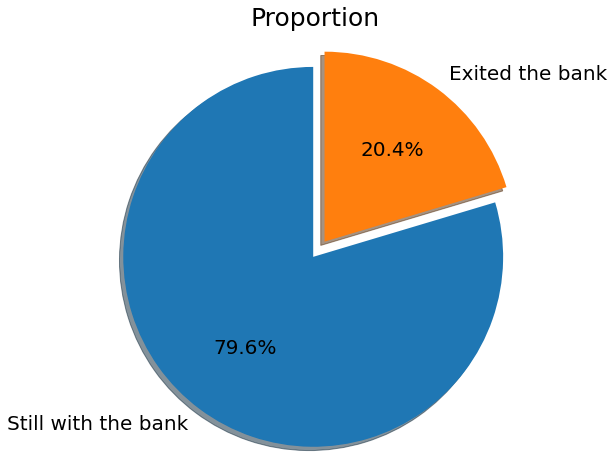

In [73]:
# print(Data.Target.value_counts())
labels = 'Still with the bank', 'Exited the bank'
sizes = [cust.exited[cust['exited']==0].count(),cust.exited[cust['exited']==1].count()]
explode = (0, 0.1)
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize':20})
ax.axis('equal')
plt.title("Proportion", size = 25)
plt.show()

* This pie chart shows that the actual distribution of classes is itself imbalanced for the target variable.
* Only ~20% of the customers in this dataset have exited the bank.

Hence, this dataset and problem statement represent an example of Imbalanced Classification, which has unique challenges in comparison to performing classification over balanced target variables.

- #### Bivariate analysis of numerical features

In [74]:
### Function to plot distributions
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    fig.suptitle('Analysis of the Target variable w.r.t. '+ predictor, fontsize=15)

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for " + target +'='+ str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for " + target +'='+ str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    # plt.tight_layout()
    plt.show()

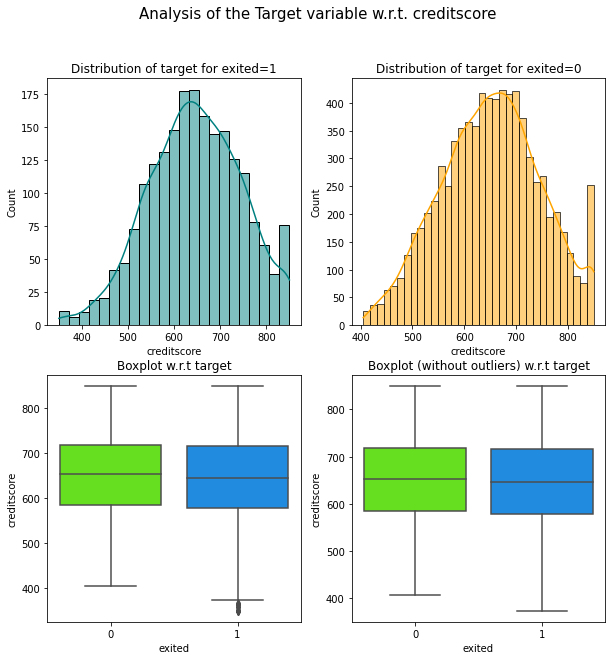

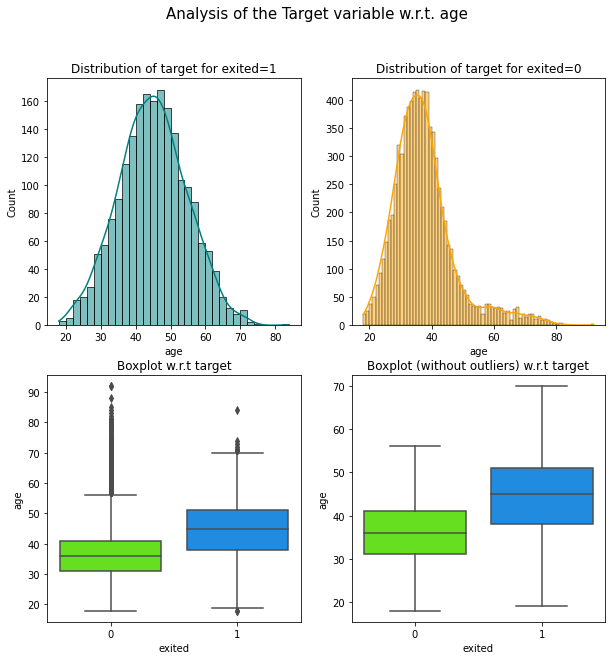

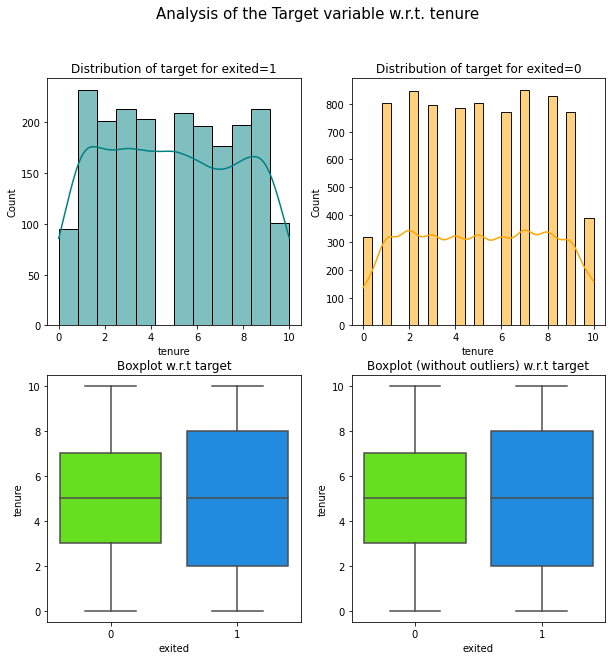

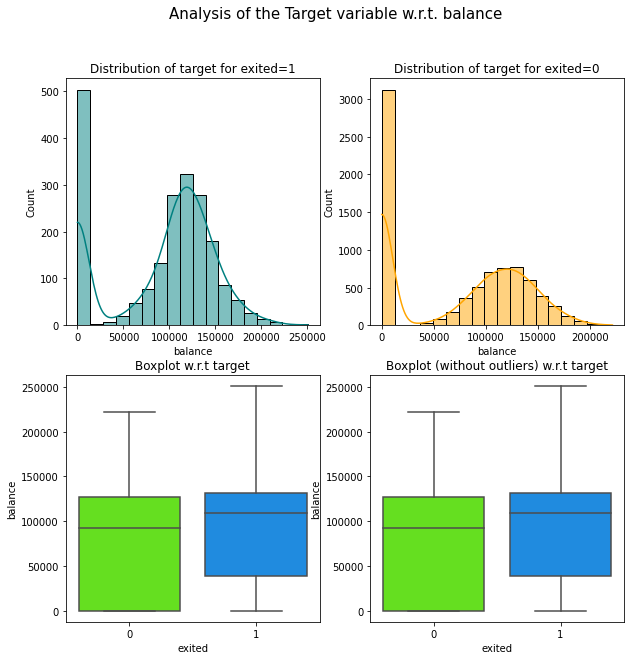

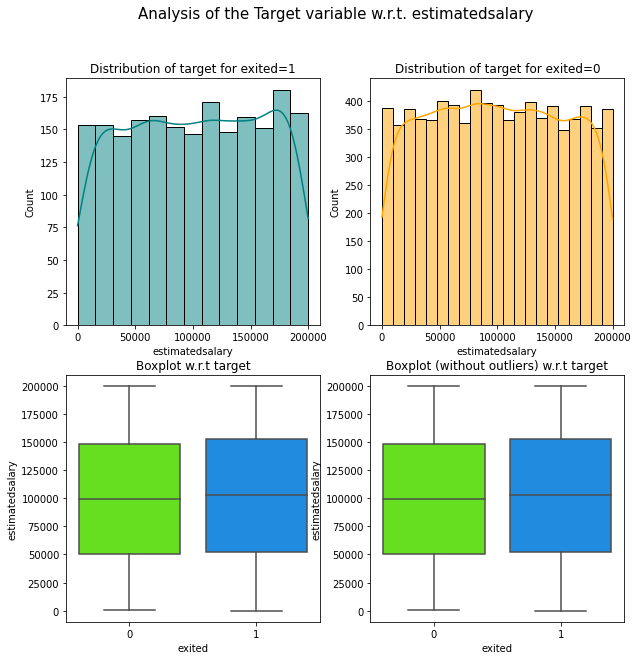

In [75]:
for numcol in numcols:

    distribution_plot_wrt_target(cust, numcol, 'exited')

#### Observations on bivariate analysis of customers leaving the bank w.r.t. numerical variables

- The creditscore of customers who exited the bank is slightly lower than the customers who have stayed with the bank.

- The age of customers leaving the bank are about 10 years older than the customer who are sticking with the bank

- The tenure for customers who leave and who stay is nearly the same and is a uniform distribution for both of them

- The balance for customers who leave the bank is slightly higher than the customers who stick with the bank.

- The estimatedsalary for the customers who left the bank is slightly higher than the customers who stayed with the bank.


- #### Bivariate analysis of categorical features

In [76]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title('Stacked barplot for ' + predictor + ' w.r.t. ' + target, fontsize = 15)
    plt.show()

exited        0     1    All
geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


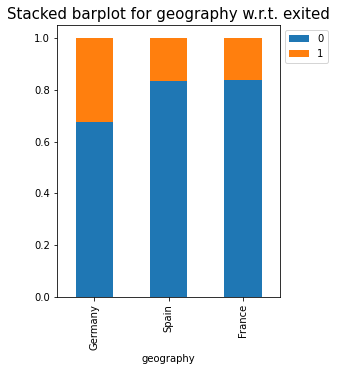

exited     0     1    All
gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


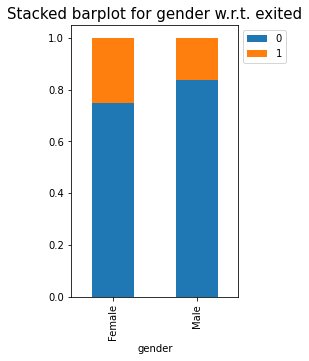

exited        0     1    All
hascrcard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


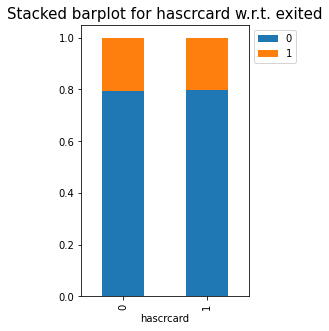

exited             0     1    All
isactivemember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


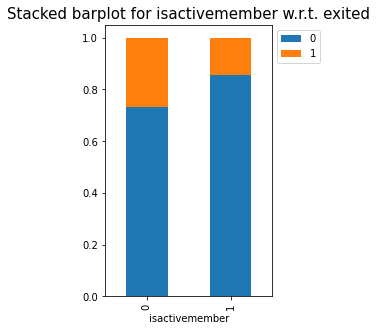

exited            0     1    All
numofproducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


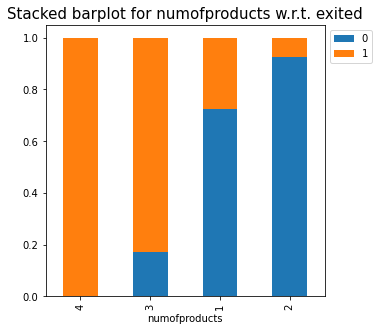

In [77]:
for catcol in catcols:
    if catcol == 'exited':
        continue
    stacked_barplot(cust, catcol, 'exited')

#### Observations on bivariate analysis of customers leaving the bank w.r.t. categorical variables

- The geography feature of customers indicates that a significant higher portion of the customers in Germany left the bank, and slightly small but similar proportions of customers left the bank in Spain and France.

- The gender feature of customers indicate that more feamles leave the bank compared to male customers

- Having credit card doesn't really affect the proportion of customers leaving the bank.
  - Hence, we will drop this column from our analysis

- Being an active member of the bank indicates that the customer is likely to stick around

- It is a reasonable assumption to say that the more number of products the customer use, the high are the chances they will exit the bank.
  - All the customers who used 4 products, left the banks.
  - Nearly 80% of customers who used 3 products left the bank.

- #### Drop the hascrcard from the dataset

In [78]:
###Dropping these columns as they will not add value to the modeling
# cust.drop(['hascrcard'], axis=1, inplace=True)

## **Data pre-processing**

- #### Splitting dataset into features and target variables

In [79]:
## Separating Independent and Dependent Columns
X = cust.drop(['exited'],axis=1)
Y = cust[['exited']]

- #### Splitting dataset into train, validation and test

In [80]:
# Splitting the dataset into the Training and Testing set.
X_train, X_small, Y_train, Y_small = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)

# Splitting the Training dataset into the Training and validation set.
X_test, X_val, Y_test, Y_val = train_test_split(X_small,Y_small, test_size = 0.5, random_state = 42,stratify = Y_small)

# Check the sizes of test, train and validation test
print('Test dataset shape')
print('Feature dataset :', X_test.shape, ', Target dataset :', Y_test.shape)
print()
print('Train dataset shape')
print('Feature dataset :',X_train.shape, ', Target dataset :', Y_train.shape)
print()
print('Validation dataset shape')
print('Feature dataset :',X_val.shape, ', Target dataset :', Y_val.shape)

# Check for any missing values in either test, train and validation sets
print()
print("-" * 30)
print(X_train.isna().sum())
print()
print(Y_train.isna().sum())
print("-" * 30)
print(X_test.isna().sum())
print()
print(Y_test.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print()
print(Y_val.isna().sum())
print("-" * 30)

Test dataset shape
Feature dataset : (1000, 10) , Target dataset : (1000, 1)

Train dataset shape
Feature dataset : (8000, 10) , Target dataset : (8000, 1)

Validation dataset shape
Feature dataset : (1000, 10) , Target dataset : (1000, 1)

------------------------------
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
dtype: int64

exited    0
dtype: int64
------------------------------
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
dtype: int64

exited    0
dtype: int64
------------------------------
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0


- #### Encoding Categorical Columns

In [82]:
# list the columns to encode
cols_to_encode = ['geography', 'gender']#, 'numofproducts']

# make a dictionary to store labelencoders
labelencoders = {}

# loop over the features to encode
for col_to_encode in cols_to_encode:
  # Initiate labelencoder
  labelencoders[col_to_encode] = LabelEncoder()
  # Fit and transform the training dataset
  X_train[col_to_encode] = labelencoders[col_to_encode].fit_transform(X_train[col_to_encode])
  # Transform the test and validation dataset
  X_test[col_to_encode] = labelencoders[col_to_encode].transform(X_test[col_to_encode])  
  X_val[col_to_encode] = labelencoders[col_to_encode].transform(X_val[col_to_encode])

- #### Scaling the numerical columns

In [83]:
# Initiate standard scaler
sc = StandardScaler()

## Apply standard scaler to relevant cols ##
# Fit and transform the training dataset
X_train[numcols] = sc.fit_transform(X_train[numcols])
# Transform the test and validation dataset
X_test[numcols] = sc.transform(X_test[numcols])
X_val[numcols] = sc.transform(X_val[numcols])

In [84]:
X_train

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
2151,1.058568,0,1,1.715086,0.684723,-1.226059,1,1,0,1.042084
8392,0.913626,1,1,-0.659935,-0.696202,0.413288,1,1,0,-0.623556
5006,1.079274,1,0,-0.184931,-1.731895,0.601687,2,1,1,0.308128
4117,-0.929207,0,1,-0.184931,-0.005739,-1.226059,2,1,0,-0.290199
7182,0.427035,1,1,0.955079,0.339492,0.548318,2,0,1,0.135042
...,...,...,...,...,...,...,...,...,...,...
4555,0.385623,2,0,-0.374933,0.339492,-1.226059,1,1,0,-1.294966
4644,0.634095,2,1,3.330101,-0.005739,-1.226059,2,0,0,0.901685
8942,0.168210,0,0,-0.184931,1.375185,-0.073747,2,1,1,-0.558088
2935,0.375270,2,1,-0.374933,1.029954,0.394991,2,1,0,-1.351500


In [86]:
for numcol in numcols:
  # Check for mean and std on test, train and validation sets
  print()
  print('Training data: Mean of', numcol, '=', X_train[numcol].mean(), 'and std of', numcol, '=', X_train[numcol].std())  
  print('Testing data: Mean of', numcol, '=', X_test[numcol].mean(), 'and std of', numcol, '=', X_test[numcol].std())  
  print('Validation data: Mean of', numcol, '=', X_val[numcol].mean(), 'and std of', numcol, '=', X_val[numcol].std())
  print("-" * 30)


Training data: Mean of creditscore = -5.728750807065808e-16 and std of creditscore = 1.0000625058599855
Testing data: Mean of creditscore = -0.037669377288373156 and std of creditscore = 0.9986119929144718
Validation data: Mean of creditscore = 0.014509724411062826 and std of creditscore = 1.0075905073898006
------------------------------

Training data: Mean of age = 2.486899575160351e-16 and std of age = 1.0000625058599855
Testing data: Mean of age = 0.010390721026878848 and std of age = 0.9908534536276778
Validation data: Mean of age = -0.03397468898045652 and std of age = 0.972155620360473
------------------------------

Training data: Mean of tenure = -9.814371537686384e-17 and std of tenure = 1.0000625058599855
Testing data: Mean of tenure = -0.026453338223216334 and std of tenure = 0.9748960427603544
Validation data: Mean of tenure = 0.0132482460595878 and std of tenure = 1.009500180849442
------------------------------

Training data: Mean of balance = 5.773159728050814e-17 an

- The standard scaling of the dataset looks good,
    - The mean is nearly zero for all numerical features
    - The standard deviation of all features is close to 1

- There is a slightly higher absolute value of mean and std other than 0 and 1 on test and validation set, as the standard scaler is trained on the training data set

## **Model Building**

#### **A model can make wrong predictions in the following ways:**
* False Positives : Predicting a customer is going to leave the bank (1), when they do not leave the bank (0).
* Flase Negatives : Predicting a customer is going to continue with the bank (0), when they actually leave the bank (1).

#### **Which case is more important?**

Both cases are actually important for the purposes of this case study. The bank invests resources in keeping the customers engaged with the bank. 

- If the customer leaves the bank after bank invested in keeping them around, bank loses money on engagement along with their investment in the bank. 

- If the customer sticks with the bank after bank invested in keeping them around, bank only spend enagegement resources on someone who ended up sticking around.

So, both the losses from customers leaving and spending resources on customers who won't leave are important. Hence we will use Fᵦ score (β=1.5) to find the optimum threshold for classification of customers. The β=1.5 gives slightly higher weightage to recall maximization then precision.

#### **How to reduce this loss i.e need to reduce False Negatives**

The bank would want the Fᵦ score (β=1.5) evaluation metric to be maximized/ Hence, the focus should be on increasing the recall. We will also track F1 score along as well. 


- #### Useful functions for model development and evaluations

- ##### Confusion Matrix

In [87]:
def make_confusion_matrix(cf, axis,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax=axis)
    axis.set_xlabel('Predicted', fontsize=15)
    axis.set_ylabel('Actual', fontsize=15)

    
    if title:
        plt.title(title)

- ##### Clear backend

In [88]:
def clear_backend():
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)

- ##### Plot the loss with epochs

In [89]:
def plot_loss_accuracy(history):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize= (12,5))
  fig.suptitle('Loss and Accuracy', fontsize=20)

  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='validate')
  ax1.legend()
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')

  ax2.plot(history.history['accuracy'], label='train')
  ax2.plot(history.history['val_accuracy'], label='validate')
  ax2.legend()
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')

- ##### Obtain the optimum threshold from ROC-AUC curve and show confusion matrix

In [90]:
from scipy.interpolate import interp1d
def plot_rocauc_confmat(model, X, Y, threshold_metric):

  # predict probabilities
  Yhat = model.predict(X)
  # keep probabilities for the positive outcome only
  Yhat = Yhat[:, 0]
  # calculate roc curves and area under it and recall/precision values
  fpr, tpr, thresholds = roc_curve(Y, Yhat)
  auc = roc_auc_score(Y, Yhat)
  # Get precision and recall and interpolate it over the grid of roc-auc curve
  precision_temp, recall_temp, threshold_temp = precision_recall_curve(Y, Yhat)
  precision = interp1d(threshold_temp, precision_temp[1:], fill_value='extrapolate')(thresholds)
  recall = interp1d(threshold_temp, recall_temp[1:], fill_value='extrapolate')(thresholds)

  # calculate the g-mean for each threshold
  indicator_type = threshold_metric
  if indicator_type == 'G-Mean':
    indicator = np.sqrt(tpr * (1-fpr))
  elif indicator_type == 'YoudenJ':
    indicator = tpr - fpr
  else:
    indicator = np.zeros(len(thresholds))
    for index, elem in enumerate(thresholds):
      Ypred_prob = (Yhat > elem).astype('int')
      indicator[index] = fbeta_score(Y, Ypred_prob, beta=1.5)
  # locate the index of the largest value of indicator
  ix = np.argmax(indicator)

  # Initiate Figure
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize= (12,10))
  fig.suptitle('Threshold=%f, Recall=%.3f, Precision=%.3f, %s = %.3f, AUC=%.3f' % (thresholds[ix], tpr[ix], 
                                                                                   precision[ix], indicator_type, 
                                                                                   indicator[ix], auc), 
               fontsize=15)
  
  # plot the roc curve for the model
  ax1.plot([0,1], [0,1], 'r--', label='No Skill')
  ax1.plot(fpr, tpr, c='b')
  ax1.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  ax1.set_xlabel('False Positive Rate', fontsize=15)
  ax1.set_ylabel('True Positive Rate', fontsize=15)
  ax1.legend()

  # plot the roc curve for the model
  ax2.plot(recall_temp, precision_temp,c='b')
  ax2.scatter(tpr[ix], precision[ix], marker='o', color='black', label='Best')
  ax2.set_xlabel('recall', fontsize=15)
  ax2.set_ylabel('precision', fontsize=15)
  ax2.legend()

  # plot the roc curve for the model
  ax3.plot(thresholds, indicator,c='b')
  ax3.scatter(thresholds[ix], indicator[ix], marker='o', color='black', label='Best')
  ax3.set_xlabel('Threshold', fontsize=15)
  ax3.set_ylabel(indicator_type, fontsize=15)
  ax3.set_xlim([0, 1])
  ax3.legend()

  # Show the confusion matrix
  Ypred = (Yhat > thresholds[ix])
  cm=confusion_matrix(Y, Ypred)
  labels = ['True Negative','False Positive','False Negative','True Positive']
  categories = [ 'Continuing','Exiting']
  make_confusion_matrix(cm, ax4,
                        group_names=labels,
                        categories=categories, 
                        cmap='Blues',
                        # figsize = (6.5,5),
                        )

- ### Model 1

We wil build our first Neural Network.

In [91]:
# Clear the backend
clear_backend()

# Initializing the ANN
model1 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', input_dim = X_train.shape[1]),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform'),
                     Dense(32, activation='relu', kernel_initializer='he_uniform'),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model1.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
250/250 [==============================] - 1s 2ms/step - loss: 0.4699 - accuracy: 0.7889 - val_loss: 0.4324 - val_accuracy: 0.8060
Epoch 2/30
250/250 [========================

- #### Evaluate Model 1 performance

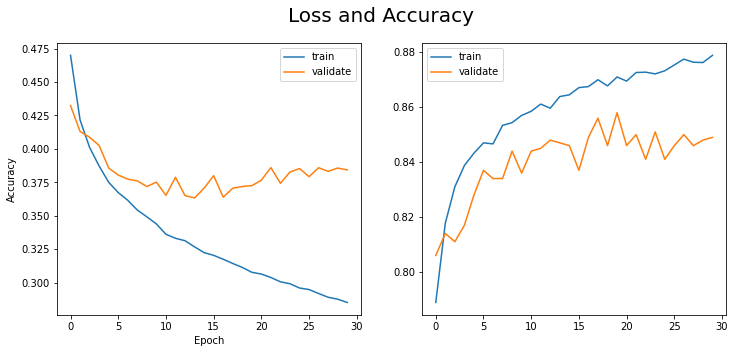

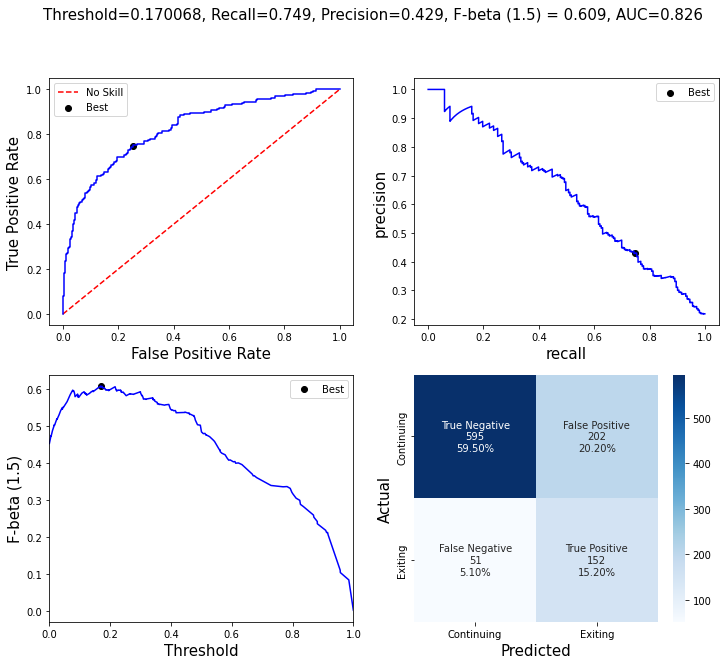

In [92]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history1)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model1, X_val, Y_val, 'F-beta (1.5)')

- The model used in this trial is a simpler model 
- The model overfits after approximately 10 epochs
- We used Fβ score for finding the right threshold (0.17)
- We will next try a deeper neural network and see if we see any improvement in model performance

- ### Model 2

We wil build our second Neural Network.

In [93]:
# Clear the backend
clear_backend()

# Initializing the ANN
model2 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', input_dim = X_train.shape[1]),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform'),
                     Dense(128, activation='relu', kernel_initializer='he_uniform'),
                     Dense(256, activation='relu', kernel_initializer='he_uniform'),
                     Dense(128, activation='relu', kernel_initializer='he_uniform'),
                     Dense(64, activation='relu', kernel_initializer='he_uniform'),
                     Dense(32, activation='relu', kernel_initializer='he_uniform'),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model2.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2

- #### Evaluate Model 2 performance

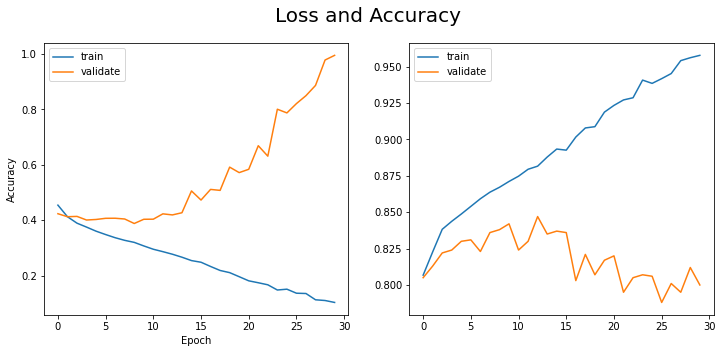

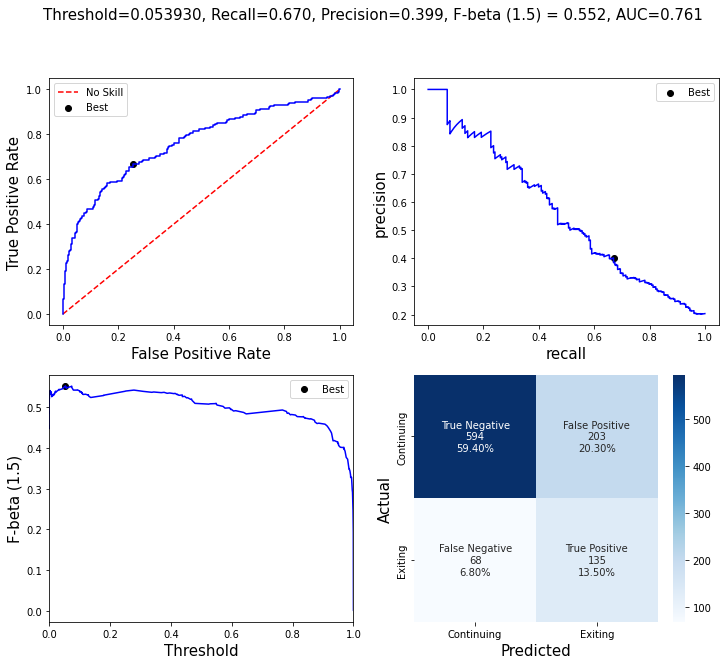

In [94]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history2)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model2, X_val, Y_val, 'F-beta (1.5)')

- The deeper network is doing a bad job at making predictions then a simpler network
- It is clearly overfitting the training data in very early epochs
- The recall has reduced and the precision has increased slightly 
- We will now try to reduce the overfitting in the deeper neural network by using 
  1. Batch Normalization with L2 regularizer
  2. Dropout with L2 regularizer
  

- ### Model 3

We will build our third Neural Network with batch normalization and L2 regularization

In [95]:
# Clear the backend
clear_backend()

# Initializing the ANN
model3 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_dim = X_train.shape[1]),
                     BatchNormalization(),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     BatchNormalization(),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model3.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history3 = model3.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

- #### Evaluate Model 3 performance

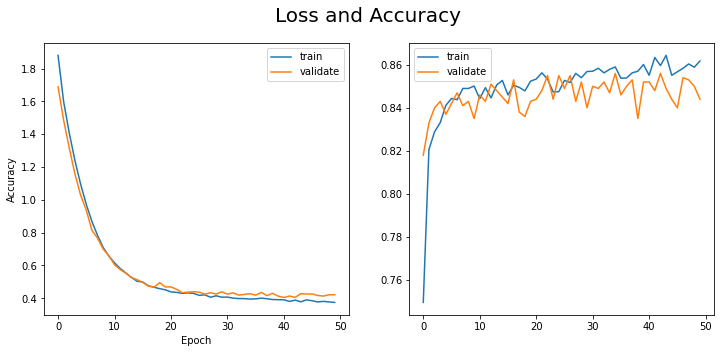

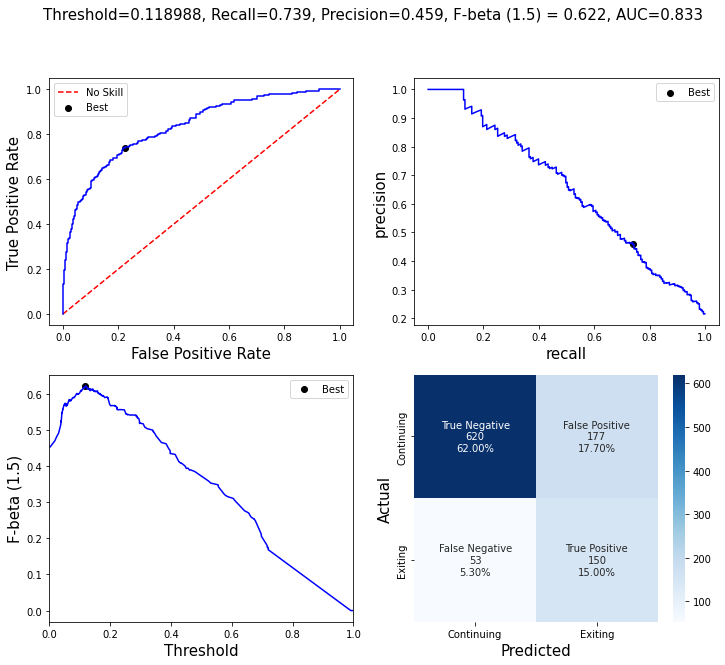

In [ ]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history3)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model3, X_val, Y_val, 'F-beta (1.5)')

- We have significantly reduced the overfitting in the model
- The recall has increased and so has the F-beta score

- ### Model 4

We will build our third Neural Network with dropout and L2 regularization

In [ ]:
# Clear the backend
clear_backend()

# Initializing the ANN
model4 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_dim = X_train.shape[1]),
                     Dropout(0.2),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model4.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history4 = model4.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               3

- #### Evaluate Model 4 performance

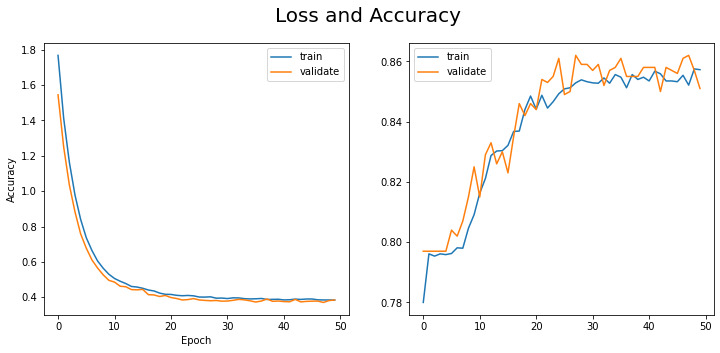

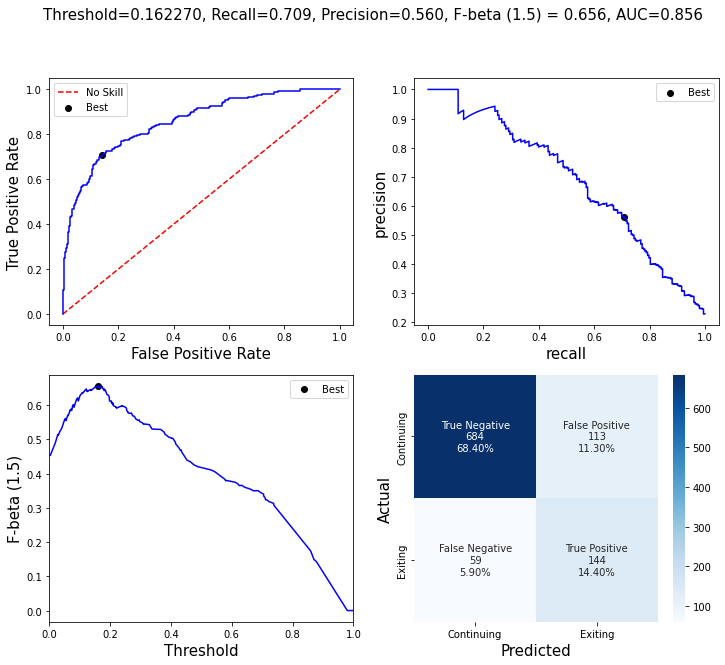

In [ ]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history4)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model4, X_val, Y_val, 'F-beta (1.5)')

- This model has the best AUC ROC value as well as the highest Fbeta score.
- The recall is slightly lower than model3
- For next step we will try to oversample the training data and train it on model4 neural net

- ### Model 5

We will build our fifth Neural Network with dropout and L2 regularization which is trained over oversampled data

In [ ]:
# To do oversmapling and undersampling of data
from imblearn.over_sampling import SMOTE
print("Before Oversampling, counts of label 'Exited': ", np.count_nonzero(Y_train==1))
print("Before Oversampling, counts of label 'Continuing': ", np.count_nonzero(Y_train==0), '\n')

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, Y_train_over = sm.fit_resample(X_train, Y_train)


print("After Oversampling, counts of label 'Exited': ", np.count_nonzero(Y_train_over==1))
print("Before Oversampling, counts of label 'Continuing': ", np.count_nonzero(Y_train_over==0), '\n')


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(Y_train_over.shape))

Before Oversampling, counts of label 'Exited':  1630
Before Oversampling, counts of label 'Continuing':  6370 

After Oversampling, counts of label 'Exited':  6370
Before Oversampling, counts of label 'Continuing':  6370 

After Oversampling, the shape of train_X: (12740, 10)
After Oversampling, the shape of train_y: (12740, 1) 



In [ ]:
# Clear the backend
clear_backend()

# Initializing the ANN
model5 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_dim = X_train.shape[1]),
                     Dropout(0.2),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model5.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history5 = model5.fit(X_train_over, Y_train_over, validation_data=(X_val, Y_val), epochs=50, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               3

- #### Evaluate Model 5 performance

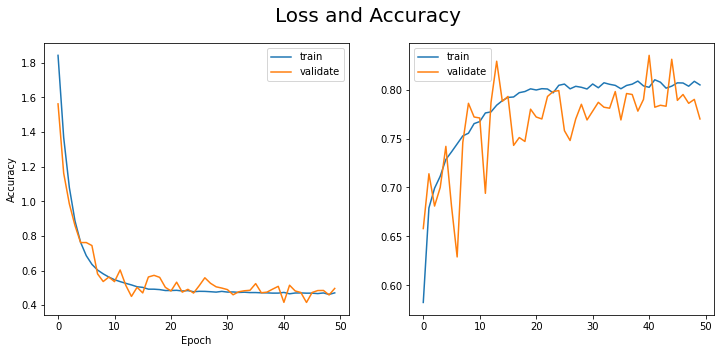

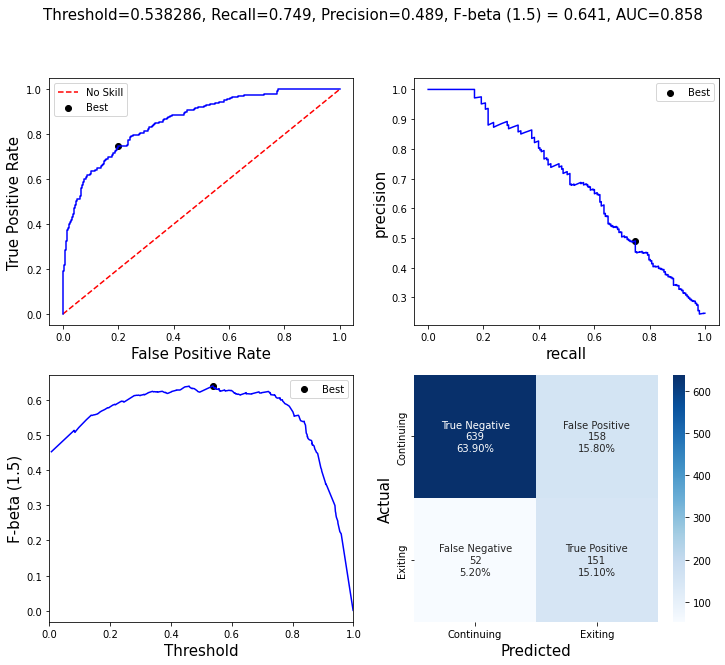

In [ ]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history5)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model5, X_val, Y_val, 'F-beta (1.5)')

- The oversampled model does not provide a great improvement over the training on actual training data.
- Next, we will give undersampling a try

- ### Model 6

We will build our sixth Neural Network with dropout and L2 regularization which is trained over undersampled data

In [ ]:
# To do undersampling of data
from imblearn.under_sampling import RandomUnderSampler
print("Before Oversampling, counts of label 'Exited': ", np.count_nonzero(Y_train==1))
print("Before Oversampling, counts of label 'Continuing': ", np.count_nonzero(Y_train==0), '\n')

rus = RandomUnderSampler(random_state=1)  # Undersample dependent variable
X_train_under, Y_train_under = rus.fit_resample(X_train, Y_train)

print("After Oversampling, counts of label 'Exited': ", np.count_nonzero(Y_train_under==1))
print("Before Oversampling, counts of label 'Continuing': ", np.count_nonzero(Y_train_under==0), '\n')

print("After Under Sampling, the shape of train_X: {}".format(X_train_under.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(Y_train_under.shape))

Before Oversampling, counts of label 'Exited':  1630
Before Oversampling, counts of label 'Continuing':  6370 

After Oversampling, counts of label 'Exited':  1630
Before Oversampling, counts of label 'Continuing':  1630 

After Under Sampling, the shape of train_X: (3260, 10)
After Under Sampling, the shape of train_y: (3260, 1) 



In [ ]:
# Clear the backend
clear_backend()

# Initializing the ANN
model6 = Sequential([Dense(32 , activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_dim = X_train.shape[1]),
                     Dropout(0.2),                     
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
                     Dropout(0.2),
                     Dense(1, activation = 'sigmoid')])

# Summarize the model
model6.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Fitting the model
history6 = model6.fit(X_train_under, Y_train_under, validation_data=(X_val, Y_val), epochs=200, verbose=1)#, callbacks=es_cb)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               3

- #### Evaluate Model 6 performance

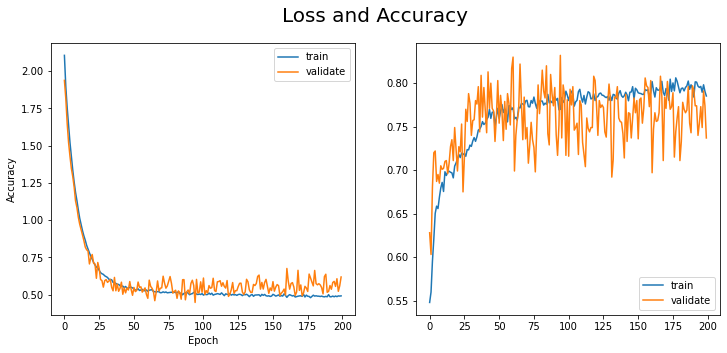

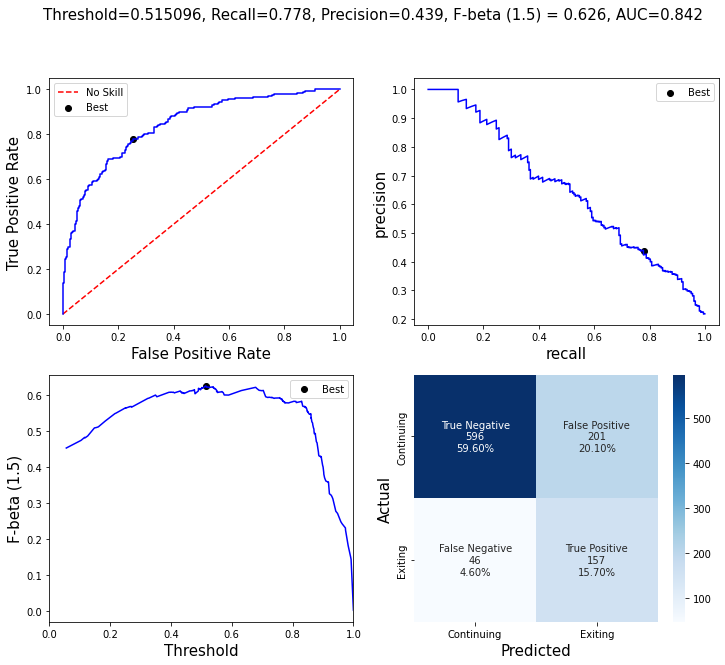

In [ ]:
# Evaluating model performance
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history6)
  # Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model6, X_val, Y_val, 'F-beta (1.5)')

- ### Modeling summary

  - As we can see that Fᵦ (β=1.5) score  is the highest for Deep Neural Network with dropout ratio = 0.2 and L2 normalization, i.e. Model4
  - We will now evaluate the model performance on test data

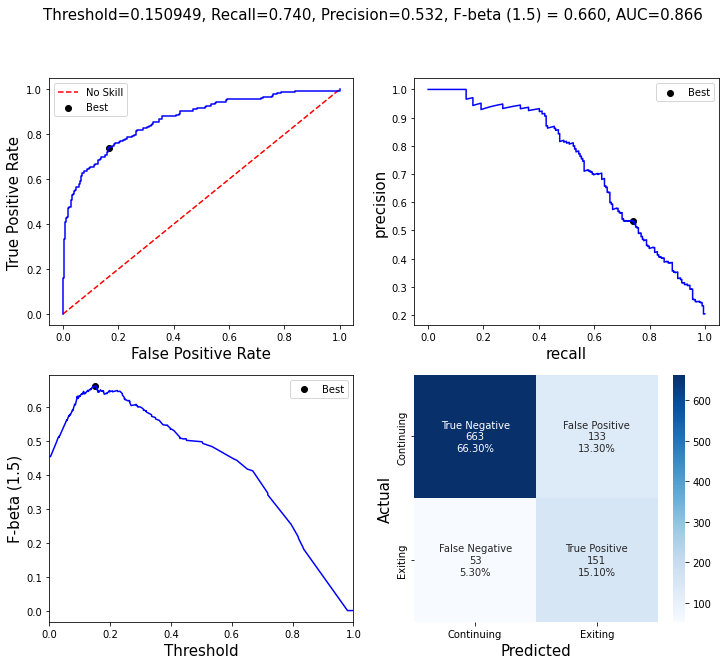

In [ ]:
# Show the ROC AUC curve and confusion matrix
plot_rocauc_confmat(model4, X_test, Y_test, 'F-beta (1.5)')

- We will now use the model4 to explore SHAP values.

## **Feature Importance**

In [ ]:
# Summarize the training set to accelerate analysis
explainer = shap.KernelExplainer(model4.predict, shap.kmeans(X_train.values, 50))
shap_values = explainer.shap_values(X_test.values)

- #### Show the feature importance plots

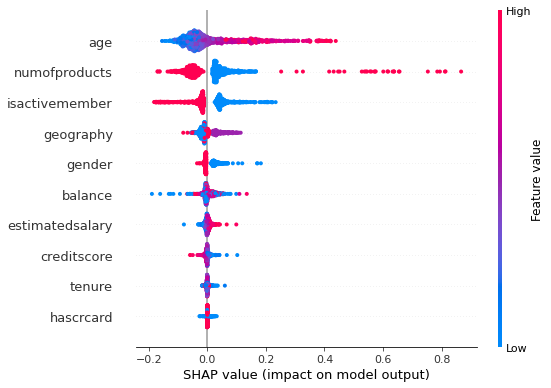

In [ ]:
shap.summary_plot(shap_values[0], X_test)

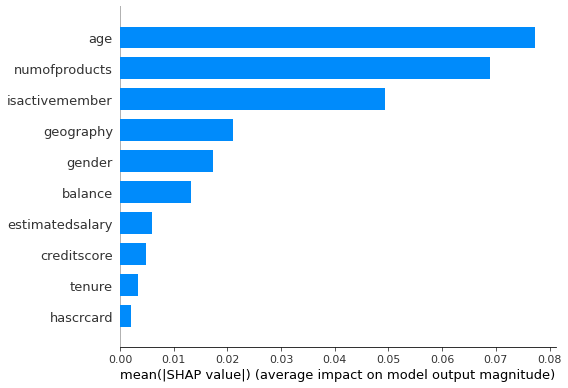

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

- We can see from these SHAP values that our top 3 influencers for a customer exiting the bank are,
  1. Age
    - Higher the age of the customer the more likely they are to leave the bank
  2. Number of Products used by the customer
    - The more the products that customer use more likely that the leave the bank
  3. If the customer is an active bank member
    - The less active the bank member is more likely that they will exit

- One import fact to notice is that, in our EDA, we discovered that the customer having a credit card doesn't have a significant impact on them exiting the bank. This is also, shown in the SHAP values, where the hascrcard has the lowest importance amongst all the parameters.

## **Summary and Business reccomendations**

- ### **Summary**  <br>

    - We have analyzed bank customer data to predict if they will leave/exit the bank
    - We have used Neural Network based classifier to make the exit/continuation prediction
    - We evaluated our models performance based on Fᵦ score (β = 1.5) which gives slightly higher weightage to recall (reducing false negatives/customers who predicted to continue but actuallly left) over precision (reducing false positive/customers who predicted to leave but actuallly continued)
    - We evaluated our model performance based on Fᵦ score (β = 1.5) and found that the deep neural network model with dropout (ratio = 0.2) and L2 regularization was the best performer. Before concluding that, we analyzed following models,
      1. A shallow neural network: This tends to overfit and had a rugged loss function
      2. A deep neural network: This tend to overfit the training data very quickly, but the loss function was smoother
      3. A deep neural network with batch normalization and L2 normalization: This significantly reduced the overfitting and loss function was smooth.
      4. A deep neural network with dropout and L2 normalization: Again, a significant reduction in overfitting and smooth loss function. This model gave the best Fᵦ score (\beta = 1.5).
      5. A deep neural network with dropout and L2 normalization trained over oversampled data: This did not further improve the model #4.
      6. A deep neural network with dropout and L2 normalization trained over undersampled data: This did not further improve the model #4.
  
  - Hence, we used the model #4 for making conclusions rgearding the model and business takeaways.

- ### **Business Recommendations**   <br>

- Here we will provide cluster specific business recommendations.

  - **Takeaways from EDA**
    - The customers who exited the bank had sligtly lower credit score on an average
    - The customers who exited have significantly higher age than the customers who continued
    - The customers who exited have higher balance and estimated salary than who continued
    - The customers who are from Germany have a higher chance of leaving compared to the ones from Spain or France
    - Female customers have higher chance of leaving the bank compared to male customers
    - The customers who have be less active are more likely to leave the bank
    - The cusotmers who use more products from the bank are more likely to leave the bank
  
  - **Takeaways from NN model**
    - Following are the most crucial parameters for customers exit from the bank
      - *Age* : Higher the age of the customer the more likely they are to leave the bank
      - *Number of Products used by the customer* : The more the products that customer use more likely that the leave the bank
      - *If the customer is an active bank member* : The less active the bank member is more likely that they will exit
  
  - **Recommendations**
    - Based on our analysis we can clearly see that we need to focus more on following segment of customers
      - The older customers are leaving the bank
        - The chance are that older customers are the ones who have more financial assets and are looking for a better place for investing it
        - The technology to access bank resources are difficult for the elder folks
        - *This indicates that the bank needs to look into the technological resources and also start to offer age based benefits to their customers*

      - The customers who use the higher number of products tend to leave the bank
        - Again this points towards the technological issues faced by customers who are using more bank products and also in person access
        - *This indicates that bank seriously needs to consider their products tenchology and customer service*

      - The customers who don't use the bank resources tend to leave the bank
        - This should be considered as a last warning for the bank. If a customer moves into the category of "not an active member" the customer are likley to leave
        - *This indicates that bank needs to pitch benefits to customers who fall into the "not an active member"*

